## Comparing DLC Camera CSV 3D coordinate Data to Autobender/Rotary Encoder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import path_to_repository
from analysis import DLC3DBendAngles
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#load rotary encoder csv, camera 3d data form DLC csv, and flir_data.mat with timestamps from python camera acquisition

renc = os.path.join(path_to_repository , "CSV Data/8_20_25/data_rotenc_2025_08_20_18_37_05.csv")
df_renc = pd.read_csv(renc)  
cam = os.path.join(path_to_repository , "CSV Data/8_20_25/camera-1-2025_08_20_18_37_05DLC_Resnet50_0815Aug16shuffle1_snapshot_010.csv")
#cam = os.path.join(path_to_repository , "CSV Data/8_20_25/2025_08_20_18_37_05_DLC_3D.csv")
cam_timestamp = os.path.join(
    path_to_repository,
    "CSV Data/8_20_25/flir_data.mat"
)



In [5]:
#load DLC 3d coordinates from DLC triangulation
cam = DLC3DBendAngles(cam)

# Load only variables starting with 'ts' -> timestamp data
df_ts = cam.load_mat_as_df(cam_timestamp, prefix="ts")

In [6]:
#check number of rows from  cam dataframe (taken from DLC csv) and df_ts dataframe (timestamps form flir_data.mat file).  They hopefully are the same.  If not, need to determine which frames dropped.
#rows_renc, rows_cam = DLC3DBendAngles.compare_row_counts(cam.df, df_ts)

In [7]:
#add camera timestamp columns to 3d dlc data
cam.add_dataframe(df_ts)

In [8]:
# Drop all rows where likelihood is less than threshold

# --- define the likelihood columns you care about ---
#likelihood_cols = [
#    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "PIP", "likelihood"),
#    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "MCP", "likelihood"),
#    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "hand", "likelihood"),
#]

# --- apply filter: keep rows where ALL ≥ 0.82 ---
#mask = (cam.df[likelihood_cols] >= 0.7).all(axis=1)
#cam.df = cam.df[mask].copy()

## Bend Angle obtained from Dot Product Formula

## $\theta = \cos^{-1} \left( \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \, \|\mathbf{v}_2\|} \right)$

As an example:  

V1 is vector from hand to MCP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)

V2 is vector from MCP to PIP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)


In [10]:
#Calculte bend angles from DLC 3d trianglulated data

# --- MCP bend ---
hand_pts = cam.get_points("hand")
mcp_pts  = cam.get_points("MCP")
pip_pts  = cam.get_points("PIP")

v1_mcp = cam.vector(hand_pts, mcp_pts)  # hand→MCP
v2_mcp = cam.vector(mcp_pts, pip_pts)   # MCP→PIP
#angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp) # old way of calculting angle without projection onto wrist plane



# angles_mcp_in_wrist_plane now reflects MCP bend measured strictly within the wrist plane.
# Rows where the wrist plane is ill-defined (nearly collinear or zero vectors) are NaN (plane_ok == False).

# --- Wrist angle ---
forearm_pts = cam.get_points("forearm")
hand_pts = cam.get_points("hand")
mcp_pts = cam.get_points("MCP")

v1_wrist = cam.vector(forearm_pts, hand_pts)  # forearm→hand
v2_wrist = cam.vector(hand_pts, mcp_pts)      # hand→MCP
angles_wrist = cam.angle_from_vectors(v1_wrist, v2_wrist)

# --- MCP bend, but constrained to the wrist plane ---
angles_mcp, v1_mcp_proj, v2_mcp_proj, plane_ok = cam.angle_from_vectors_in_plane(
    v1=v1_mcp,
    v2=v2_mcp,
    plane_v1=v1_wrist,
    plane_v2=v2_wrist,
    signed=True  # set False if you prefer 0–180°
)

# --- Add both angles to a copy of the DataFrame ---
df_out = cam.df.copy()
df_out[("metric", "mcp_bend_deg", "deg")]   = angles_mcp
df_out[("metric", "wrist_bend_deg", "deg")] = angles_wrist

cam.add_dataframe(df_out)



In [11]:
# Count how many NAN's in MCP Bend Angle ->  max should be size of number of timestamps from camera data 

col_name = ("metric", "mcp_bend_deg", "deg")  # tuple key in MultiIndex

# Count NaNs
num_nans = cam.df[col_name].isna().sum()

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"NaNs in MCP bend angle: {num_nans} / {total_rows} rows")
print(f"Percent missing: {100 * num_nans / total_rows:.2f}%")

NaNs in MCP bend angle: 0 / 199 rows
Percent missing: 0.00%


In [12]:
cam.df

,"(scorer, bodyparts, coords)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, likelihood)",...,"('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'radius_styloid_process', 'x')_ts","('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'radius_styloid_process', 'y')_ts","('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'radius_styloid_process', 'likelihood')_ts","('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'forearm', 'x')_ts","('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'forearm', 'y')_ts","('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'forearm', 'likelihood')_ts",ts_25183199_ts,ts_25185174_ts,"(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)"
0,0,307.73752,193.31961,0.836859,775.40580,351.82690,0.890922,908.46075,411.82083,0.786659,...,1422.0767,528.49490,0.886087,1760.4255,650.05280,0.874214,183711125116,183711132531,-5.547303,8.648014
1,1,307.50560,192.59079,0.857537,774.85205,351.46730,0.914274,907.62994,411.06310,0.784603,...,1421.4254,527.12940,0.828146,1759.0024,646.94904,0.882305,183711173552,183711184545,-5.396674,8.686151
2,2,308.78305,193.86148,0.823181,776.88873,352.50070,0.857445,910.04517,412.62286,0.730298,...,1423.5002,528.41000,0.878758,1760.9685,647.77710,0.841051,183711226773,183711236200,-5.578578,8.851665
3,3,308.48132,194.70093,0.766269,776.82050,352.48590,0.861685,910.23590,412.89320,0.728408,...,1423.5881,528.49570,0.868690,1762.2528,649.04456,0.828862,183711277172,183711286935,-5.741044,8.868237
4,4,308.92087,195.95807,0.761887,776.97380,351.78076,0.862475,910.39860,413.50960,0.723267,...,1423.8651,529.03937,0.872673,1762.3766,649.62946,0.842453,183711324910,183711332506,-6.414102,9.337222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,194,298.12952,179.40508,0.783905,762.90690,340.92920,0.885881,896.01340,403.86120,0.809392,...,1410.4552,522.05023,0.829092,1752.4033,645.81720,0.878000,183720904685,183720914406,-6.140642,9.527932
195,195,297.68942,179.18030,0.780676,761.56290,340.37990,0.839201,894.78595,403.38690,0.806344,...,1409.5596,520.59870,0.830405,1749.4560,643.56854,0.888720,183720951743,183720959919,-6.148780,9.614947
196,196,297.72340,177.35709,0.777392,762.33057,339.83698,0.857828,895.57336,402.31506,0.783847,...,1410.4315,520.34620,0.821606,1751.6792,644.37024,0.871992,183721012779,183721020263,-5.846595,9.334361
197,197,298.82860,180.25078,0.793611,763.03217,342.71356,0.906831,896.37170,404.88562,0.804564,...,1410.5778,523.64453,0.845422,1751.9343,647.10614,0.856070,183721052240,183721059501,-5.709055,9.190686


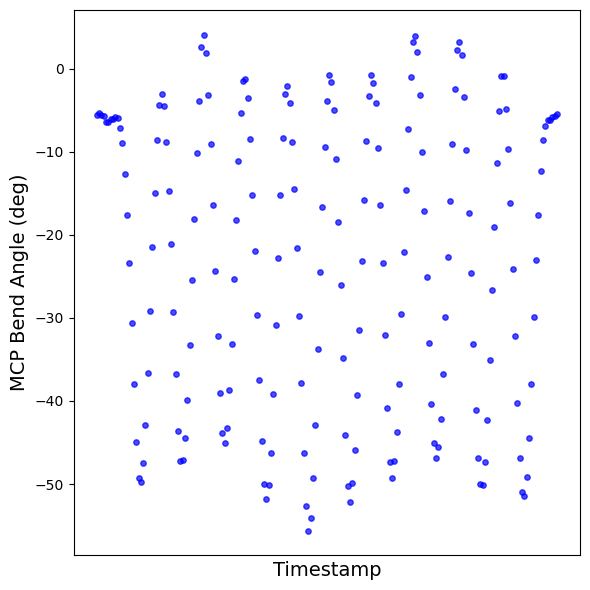

In [13]:
# Auto-detect columns by substring
ts_col  = next(c for c in cam.df.columns if "ts_25183199" in str(c))
mcp_col = next(c for c in cam.df.columns if "mcp_bend_deg" in str(c))

plt.figure(figsize=(6,6))
plt.scatter(cam.df[ts_col], cam.df[mcp_col], s=15, alpha=0.7, color="blue")
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.xticks([])
plt.tight_layout()
plt.savefig("MCP Bend vs timestamp.png", dpi=300, bbox_inches='tight')
plt.show()


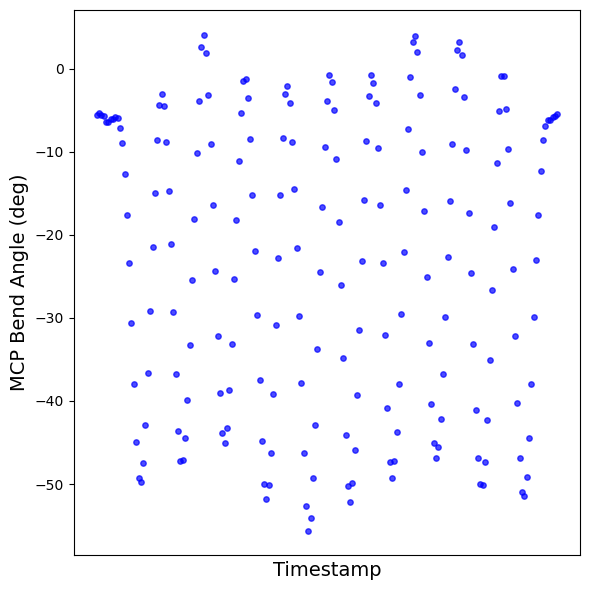

In [14]:
# --- Auto-detect columns ---
cols = cam.df.columns

# Prefer the specific camera ts; otherwise grab the first ts-like column
ts_col = next((c for c in cols if "ts_25183199" in str(c)), None)
if ts_col is None:
    ts_col = next((c for c in cols if str(c).startswith("ts_") or str(c).endswith("_ts")), None)

# Find the MCP bend column regardless of MultiIndex/flattened formatting
mcp_col = next((c for c in cols if "mcp_bend_deg" in str(c)), None)

if ts_col is None or mcp_col is None:
    raise KeyError(
        f"Could not find columns. "
        f"ts_col={ts_col}, mcp_col={mcp_col}. "
        f"Available columns (sample): {list(map(str, cols))[:10]}..."
    )

# (Optional) coerce to numeric if these came in as strings
x_ts  = pd.to_numeric(cam.df[ts_col], errors="coerce")
y_mcp = pd.to_numeric(cam.df[mcp_col], errors="coerce")

# --- Plot MCP Bend Angle vs Camera Timestamp ---
plt.figure(figsize=(6, 6))
plt.scatter(x_ts, y_mcp, s=15, alpha=0.7, color="blue")

plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.xticks([])  # hide x ticks if you prefer a cleaner look

plt.tight_layout()
plt.savefig("MCP Bend vs timestamp.png", dpi=300, bbox_inches="tight")
plt.show()


## Align Timestamps 

In [16]:
# --- pick the camera timestamp column that actually exists ---
ts_col = None
for want in ("ts_25183199", "ts_25185174"):
    # try exact, suffix “_ts”, and substring
    if want in cam.df.columns:
        ts_col = want; break
    if f"{want}_ts" in cam.df.columns:
        ts_col = f"{want}_ts"; break
    ts_col = next((c for c in cam.df.columns if want in str(c)), None)
    if ts_col is not None:
        break

if ts_col is None:
    raise KeyError(f"Couldn’t find a ts_* column in cam.df. Got: {list(cam.df.columns)[:10]} ...")

# Now do the matching with the detected column
cam.find_matching_indices(
    encoder_df=df_renc,
    cam_time_col=ts_col,       # <— use the detected string column
    enc_time_col="timestamp",
    tolerance="10ms",
    direction="nearest",
)

cam.attach_encoder_using_match(
    encoder_df=df_renc,
    columns=None,
    suffix="_renc",
    keep_time_delta=True,
    drop_unmatched=True,
)


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:1846: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:1847: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


,"(scorer, bodyparts, coords)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, likelihood)",...,"('DLC_Resnet50_0815Aug16shuffle1_snapshot_010', 'forearm', 'likelihood')_ts",ts_25183199_ts,ts_25185174_ts,"(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)",timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
0,0,307.73752,193.31961,0.836859,775.40580,351.82690,0.890922,908.46075,411.82083,0.786659,...,0.874214,183711125116,183711132531,-5.547303,8.648014,183711116203,14684,2.753250,2.635825,-8.913
3,3,308.48132,194.70093,0.766269,776.82050,352.48590,0.861685,910.23590,412.89320,0.728408,...,0.828862,183711277172,183711286935,-5.741044,8.868237,183711281814,14717,2.759438,3.016796,4.642
4,4,308.92087,195.95807,0.761887,776.97380,351.78076,0.862475,910.39860,413.50960,0.723267,...,0.842453,183711324910,183711332506,-6.414102,9.337222,183711327690,14699,2.756063,2.808993,2.780
5,5,308.92280,195.78296,0.770666,776.94600,351.35486,0.865448,910.50600,413.03473,0.718646,...,0.837985,183711377823,183711388321,-6.401235,9.305811,183711372688,14709,2.757938,2.924439,-5.135
6,6,308.50656,196.60135,0.757358,776.78810,352.89334,0.844266,910.17725,413.84650,0.726294,...,0.836738,183711428389,183711439086,-6.101617,9.099957,183711418650,14687,2.753812,2.670458,-9.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,292.46063,180.18347,0.784241,760.79785,338.23212,0.845629,894.39075,402.14865,0.769544,...,0.899325,183720851060,183720859626,-6.920564,9.765439,183720851238,14657,2.748187,2.324120,0.178
194,194,298.12952,179.40508,0.783905,762.90690,340.92920,0.885881,896.01340,403.86120,0.809392,...,0.878000,183720904685,183720914406,-6.140642,9.527932,183720895353,14700,2.756250,2.820538,-9.332
196,196,297.72340,177.35709,0.777392,762.33057,339.83698,0.857828,895.57336,402.31506,0.783847,...,0.871992,183721012779,183721020263,-5.846595,9.334361,183721011690,14728,2.761500,3.143787,-1.089
197,197,298.82860,180.25078,0.793611,763.03217,342.71356,0.906831,896.37170,404.88562,0.804564,...,0.856070,183721052240,183721059501,-5.709055,9.190686,183721057496,14710,2.758125,2.935984,5.256


In [17]:
# Create a smaller dataframe keeping only columns for following:

cols_to_keep = [
    "angle_renc",   
    ("metric", "mcp_bend_deg", "deg"),
    ("metric", "wrist_bend_deg", "deg"),
    "time_delta_renc",  # time difference between camera and rot enc timestamps
]
small_df = cam.df[cols_to_keep].copy()
small_df = small_df.dropna(subset=[("metric", "mcp_bend_deg", "deg")])
small_df = small_df.loc[:, ~small_df.columns.duplicated()].copy()


In [18]:
# Count how many remaining datapoints left  in MCP Bend Angle  after NaN removal from timestamped matched dataframe 

# Count NaNs
remain = len(small_df)

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"Rows after timestamp matching: {total_rows} rows")
print(f"Rows after dropping NaN's in MCP Bend Angle: {remain} rows")

Rows after timestamp matching: 177 rows
Rows after dropping NaN's in MCP Bend Angle: 177 rows


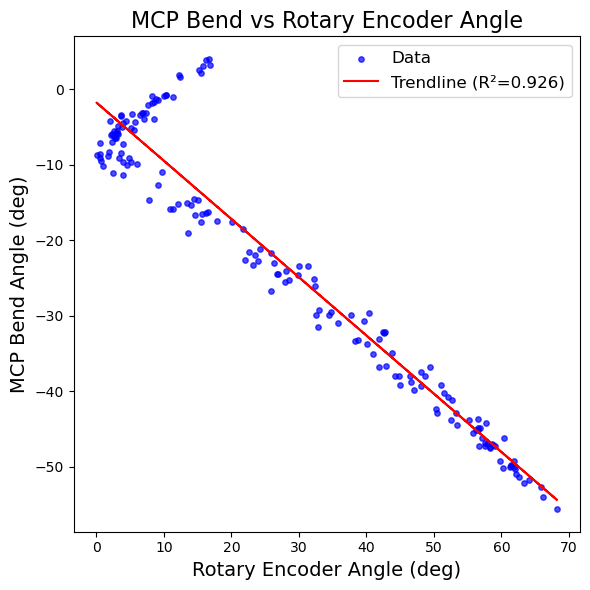

In [19]:
x = small_df["angle_renc"].to_numpy()
y = small_df[("metric", "mcp_bend_deg", "deg")].to_numpy()

# in-place (no extra array)
np.abs(x, out=x)

# Fit linear regression (y = m*x + b)
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# Compute R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=15, alpha=0.7, color="blue", label="Data")  # blue dots
plt.plot(x, y_pred, color="red", label=f"Trendline (R²={r2:.3f})")

plt.xlabel("Rotary Encoder Angle (deg)", fontsize=14)  # bigger labels
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.title("MCP Bend vs Rotary Encoder Angle", fontsize=16)

plt.grid(False)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("MCP Bend vs rot enc.png", dpi=300, bbox_inches='tight')
plt.show()


## This code is calculating abs error between camera calculated mcp bend angle (pred) and encoder angle (true).  This is not taking into account angles where plate is bend up.  Also, i am including all timestamp matched data, even where likelihood column showed values of ~ 0.7. 

In [21]:
small_df

,angle_renc,"(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)",time_delta_renc
0,2.635825,-5.547303,8.648014,-8.913
3,3.016796,-5.741044,8.868237,4.642
4,2.808993,-6.414102,9.337222,2.780
5,2.924439,-6.401235,9.305811,-5.135
6,2.670458,-6.101617,9.099957,-9.739
...,...,...,...,...
193,2.324120,-6.920564,9.765439,0.178
194,2.820538,-6.140642,9.527932,-9.332
196,3.143787,-5.846595,9.334361,-1.089
197,2.935984,-5.709055,9.190686,5.256


C:\Users\toppe\AppData\Local\Temp\ipykernel_5208\350477242.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


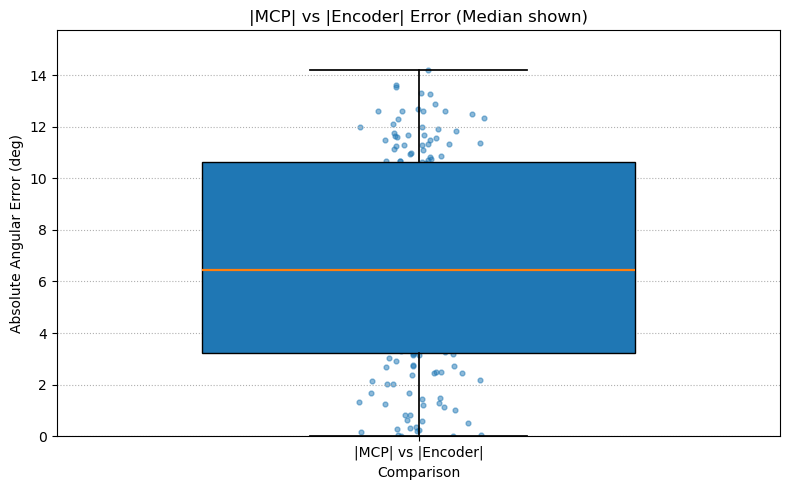

In [22]:
# --- columns in small_df ---
mcp_angle_col = ("metric", "mcp_bend_deg", "deg")   # adjust if needed
enc_angle_col = "angle_renc"
time_col      = "timestamp"  # optional

# --- pull numeric columns ---
mcp = pd.to_numeric(small_df[mcp_angle_col], errors="coerce")
enc = pd.to_numeric(small_df[enc_angle_col], errors="coerce")

# --- drop rows with NaN in either ---
mask = mcp.notna() & enc.notna()
mcp = mcp[mask]
enc = enc[mask]
ts  = small_df.loc[mask, time_col] if time_col in small_df.columns else None

# --- OPTIONAL: drop rows where encoder is negative ---
mask_pos = enc >= 0
mcp = mcp[mask_pos]
enc = enc[mask_pos]
ts  = ts[mask_pos] if ts is not None else None

# --- absolute values for both series ---
mcp_abs = np.abs(mcp.to_numpy())
enc_abs = np.abs(enc.to_numpy())
ts_arr  = ts.to_numpy() if ts is not None else None

# --- absolute error (true = |encoder|, exp = |MCP|) ---
aerr = np.abs(mcp_abs - enc_abs)

# --- tidy DataFrame (keeps your original column labels) ---
df_err = pd.DataFrame({
    enc_angle_col: enc_abs,
    mcp_angle_col: mcp_abs,
    "abs_error_deg": aerr
})
if ts_arr is not None:
    df_err[time_col] = ts_arr

# --- box plot: median shown (default), mean hidden ---
fig, ax = plt.subplots(figsize=(8, 5))
bp = ax.boxplot(
    [aerr],
    labels=["|MCP| vs |Encoder|"],
    patch_artist=True,
    showfliers=False,
    showmeans=False,
    widths=0.6
)

# simple styling (optional)
for med in bp["medians"]:
    med.set_linewidth(1.6)
for w in bp["whiskers"]:
    w.set_linewidth(1.25)
for cap in bp["caps"]:
    cap.set_linewidth(1.25)

# jittered points (optional)
x = np.random.normal(loc=1, scale=0.04, size=aerr.size)
ax.scatter(x, aerr, s=12, alpha=0.5)

# axes/limits
ax.set_xlabel("Comparison")
ax.set_ylabel("Absolute Angular Error (deg)")
if aerr.size:
    ymax = np.nanpercentile(aerr, 97.5) * 1.2
    ax.set_ylim(0, max(15, ymax))
ax.set_title("|MCP| vs |Encoder| Error (Median shown)")
ax.grid(True, axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()
